In [1]:
import ROOT
ROOT.gStyle.SetOptStat(0)
ROOT.ROOT.EnableImplicitMT(1)

myRed =   ROOT.TColor(2000, (255. / 255.), (89. / 255.), (74. / 255.))
myGreen = ROOT.TColor(2001, (25. / 255.), (170. / 255.), (25. / 255.))
myBlue = ROOT.TColor(2002, (66. / 255.), (98. / 255.), (255. / 255.))
myMagenta = ROOT.TColor(2003, (153. / 255.), (0. / 255.), (153. / 255.))
myYellow = ROOT.TColor(2004, (255. / 255.), (166. / 255.), (33. / 255.))
myAzure = ROOT.TColor(2005, (0. / 255.), (170. / 255.), (255. / 255.))
myViolet = ROOT.TColor(2006, (204. / 255.), (153. / 255.), (255. / 255.))
myOlive = ROOT.TColor(2007, (107. / 255.), (142. / 255.), (35. / 255.))
myCornFlowerBlue = ROOT.TColor(2008, (100. / 255.), (149. / 255.),(237. / 255.))
myOrangeRed = ROOT.TColor(2009, (255. / 255.), (69. / 255.), (0. / 255.))
myTeal = ROOT.TColor(2010, (0. / 255.), (128. / 255.), (128. / 255.))
myLightSteelBlue = ROOT.TColor(2011, (176. / 255.), (196. / 255.),(222. / 255.))
myGold = ROOT.TColor(2012, (255. / 255.), (215. / 255.), (0. / 255.))

## Load all prescales info first

In [2]:
import pandas as pd
lumi_MB_JP2 =  pd.read_csv("lumi_VPDMB_JP2.csv", index_col="run")
lumi_MB_HT2 =  pd.read_csv("lumi_VPDMB_BHT2.csv",index_col="run")
# keep only JP2 columns 'sampled_lumi_JP2', 'prescale_JP2', 'livetime_JP2', 'nevents_JP2', 
lumi_JP2=lumi_MB_JP2[['sampled_lumi_JP2', 'prescale_JP2', 'livetime_JP2', 'nevents_JP2']]
# add lumi_JP2 to lumi_MB_HT2
lumi=lumi_MB_HT2.join(lumi_JP2)
# show na values
# bad runs for BHT2  - 13052057 ,  13052059
# unique run for BHT2 only - 13054047 (JP2 was absent)
# drop na
lumi.dropna(inplace=True)
# drop HT2_weight
lumi.drop(columns=['HT2_weight'], inplace=True)
    #  'sampled_lumi_MB', 'prescale_MB', 'livetime_MB', 'nevents_MB',
    #  'sampled_lumi_HT2', 'prescale_HT2', 'livetime_HT2', 'nevents_HT2',
    #  'sampled_lumi_JP2', 'prescale_JP2', 'livetime_JP2', 'nevents_JP2'
# calculate ratios for JP2 and HT2 to MB
triggers = ['JP2', 'HT2']
for trigger in triggers:
    lumi[f'prescale_MB_over_{trigger}'] = lumi[f'prescale_MB'] / lumi[f'prescale_{trigger}']
    lumi[f'livetime_{trigger}_over_MB'] = lumi[f'livetime_{trigger}'] / lumi[f'livetime_MB']
    lumi[f'nevents_MB_over_{trigger}'] = lumi[f'nevents_MB'] / lumi[f'nevents_{trigger}']

In [3]:
# create a translatein map that enumerates runs
run_map = {run: i for i, run in enumerate(lumi.index.tolist())}
# creat inverse map
run_map_inv = {i: run for i, run in enumerate(lumi.index.tolist())}
# nicely print the run_map line by line
for key, value in run_map.items():
    print(f'{key}: {value}')
    # change index to the new one
lumi['runid'] = lumi.index
lumi.rename(index=run_map, inplace=True)

13048009: 0
13048010: 1
13048011: 2
13048012: 3
13048013: 4
13048014: 5
13048015: 6
13048016: 7
13048017: 8
13048018: 9
13048019: 10
13048030: 11
13048031: 12
13048032: 13
13048040: 14
13048041: 15
13048042: 16
13048043: 17
13048044: 18
13048045: 19
13048049: 20
13048050: 21
13048051: 22
13048052: 23
13048053: 24
13048087: 25
13048088: 26
13048089: 27
13048090: 28
13048091: 29
13048092: 30
13048093: 31
13049006: 32
13049007: 33
13049031: 34
13049032: 35
13049035: 36
13049039: 37
13049041: 38
13049042: 39
13049044: 40
13049045: 41
13049046: 42
13049047: 43
13049048: 44
13049049: 45
13049072: 46
13049073: 47
13049080: 48
13049081: 49
13049082: 50
13049093: 51
13049094: 52
13049096: 53
13049098: 54
13049099: 55
13049101: 56
13050001: 57
13050006: 58
13050009: 59
13050011: 60
13050012: 61
13050015: 62
13050016: 63
13050020: 64
13050022: 65
13050023: 66
13050028: 67
13050029: 68
13050031: 69
13050032: 70
13050036: 71
13050037: 72
13050038: 73
13050041: 74
13051006: 75
13051007: 76
13051008:

## Analyze the data MB, JP2, HT2

In [4]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
path='/home/prozorov/dev/star/jets_pp_2012/'
triggers = ['JP2']
tree_name = 'ResultTree'  # Update this to your tree name
branch_names = ['runid1', 'pt', 'trigger_match_jp', 'trigger_match_ht']

data={}
analyzed_events = {}

def get_event_hist(file):
    histogram = root_file["hEventsRun"] # read events per run histogram with x-labels as run ids
    runids = root_file["hEventsRun"].axis().labels()
    # turn runids into integers
    runids = [int(runid) for runid in runids]
    # read bin contents
    events = root_file["hEventsRun"].values()
    # make a pandas dataframe from it
    analyzed_events = pd.DataFrame (events, index=runids, columns=["events"])
    # drop 0's events
    analyzed_events = analyzed_events[analyzed_events["events"] > 0]
    analyzed_events.rename(index=run_map, inplace=True)
    return analyzed_events

for trigger in triggers:
    root_file_path = path + f'jets_{trigger}.root'
    root_file = uproot.open(root_file_path)
    tree = root_file[tree_name]
    tree_arrays = tree.arrays(branch_names, library="np")
        # rename colum runid1 to run
    tree_arrays['run'] = tree_arrays['runid1']
    tree_arrays.pop('runid1')
    if trigger=='JP2':
        tree_arrays['trigger_match'] = tree_arrays['trigger_match_jp']
    else:
        tree_arrays['trigger_match'] = tree_arrays['trigger_match_ht']
    tree_arrays.pop('trigger_match_jp')
    tree_arrays.pop('trigger_match_ht')

    analyzed_events.update({trigger: get_event_hist(root_file)})
    data.update({trigger: tree_arrays})

    convert = lambda runid: run_map[runid]
    data[trigger]['run'] = np.vectorize(convert)(data[trigger]['run'])
    # merge data with analyzed_events


In [5]:
trigger = 'JP2'
pt_values =            np.concatenate([arr for arr in data[trigger]['pt'] if arr.size > 0])
trigger_match_values = np.concatenate([arr for arr in data[trigger]['trigger_match'] if arr.size > 0])
# convert to int type
trigger_match_values = trigger_match_values.astype(int)

run_values =           np.concatenate([[run] * len(arr) for run, arr in zip(data[trigger]['run'], data[trigger]['pt']) if arr.size > 0])

data_df=pd.DataFrame({'run': run_values, 'pt': pt_values, 'trigger_match': trigger_match_values})
livetime_Trigger_over_MB = lumi[f'livetime_{trigger}_over_MB'].to_dict()
prescale_MB_over_Trigger = lumi[f'prescale_MB_over_{trigger}'].to_dict()
nevents_MB_over_Trigger = lumi[f'nevents_MB_over_{trigger}'].to_dict()
# make a dict from run to analyzed events from analyzed_events[trigger]
analyzed_events_Trigger = analyzed_events[trigger].to_dict()['events']
# add analyzed_events to data_df
data_df['analyzed_events'] = data_df['run'].map(analyzed_events_Trigger)
data_df[f'livetime_{trigger}_over_MB'] = data_df['run'].map(livetime_Trigger_over_MB)
data_df[f'prescale_MB_over_{trigger}'] = data_df['run'].map(prescale_MB_over_Trigger)
data_df[f'nevents_MB_over_{trigger}'] = data_df['run'].map(nevents_MB_over_Trigger)

data_df['weight'] = 1./data_df['analyzed_events']
data_df['weight_livetime'] = data_df['weight'] /data_df[f'livetime_{trigger}_over_MB']
data_df['weight_livetime_prescale'] = data_df['weight_livetime']/data_df[f'prescale_MB_over_{trigger}']
data_df['weight_livetime_prescale_nevents'] = data_df['weight_livetime_prescale']/data_df[f'nevents_MB_over_{trigger}']
# multiply by 0 when not trigger_match==0
data_df['weight_livetime_prescale_nevents_trigger'] = data_df['weight_livetime_prescale_nevents'] * (data_df['trigger_match'] )

In [6]:
# convert t
df = ROOT.RDF.FromPandas(data_df)
title = '; run ;p_{t}, GeV/c; counts per event'
nbins_pt = 20
h_norm_lt_ps_maxevt_trigger  =df.Histo2D (('h_norm_lt_ps_maxevt_trigger',   f'{trigger}+livetime+prescale+maxevents+trigger'+title,len(run_map), 0, len(run_map), nbins_pt, 5, 40), 'run', 'pt', 'weight_livetime_prescale_nevents_trigger')
# convert labels to run ids
for i in range(len(run_map)):
    h_norm_lt_ps_maxevt_trigger.GetXaxis().SetBinLabel(i+1, str(run_map_inv[i]))  

In [7]:
# find bad runs
run_projection = h_norm_lt_ps_maxevt_trigger.ProjectionX("run",4,4)
can = ROOT.TCanvas("can", "can", 1600, 600)
can.Draw()

# find those bins which have content > 40*10-6
bad_runs = []
for i in range(run_projection.GetNbinsX()):

    if run_projection.GetBinContent(i) > 4e-5:
        bad_runs.append(run_projection.GetXaxis().GetBinLabel(i))
        run_projection.SetBinContent(i, 0)

run_projection.Draw()
bad_runs
# ['13048019',
#  '13048092',
#  '13048093',
#  '13049006',
#  '13049007',
#  '13051074',
#  '13051099',
#  '13052061',
#  '13061035',
#  '13064067',
#  '13068060',
#  '13069023',
#  '13070061']
# 

['13048019',
 '13048092',
 '13048093',
 '13049006',
 '13049007',
 '13051074',
 '13051099',
 '13052061',
 '13061035',
 '13064067',
 '13068060',
 '13069023',
 '13070061']

In [8]:
%jsroot on
can = ROOT.TCanvas("can", "can", 1600, 600)
can.SetLogz()
h_norm_lt_ps_maxevt_trigger.SetMaximum(1e-1)
h_norm_lt_ps_maxevt_trigger.SetMinimum(1e-7)
h_norm_lt_ps_maxevt_trigger.Draw("colz")
can.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: can


In [ ]:
# map bad runs for JP2 
bad_runs = [
 13048019,
 13048092,
 13048093,
 13049006,
 13049007,
 13051074,
 13051099,
 13052061,
 13061035,
 13064067,
 13068060,
 13069023,
 13070061
 ]

bad_runs = [run_map[run] for run in bad_runs]
bad_runs


[10, 30, 31, 32, 33, 98, 108, 141, 289, 376, 427, 449, 485]

In [29]:
# drop bad runs
data_df = data_df[~data_df['run'].isin(bad_runs)]
# drop those runs whcih have 0 analyzed events
data_df = data_df[data_df['analyzed_events'] > 0]

df = ROOT.RDF.FromPandas(data_df)

title = '; run ;p_{t}, GeV/c; counts per event'
nbins_pt = 20

h_raw=df.Histo2D (('raw_pt_run', f'{trigger}'+ ' raw; run ;p_{t}, GeV/c; counts', len(run_map), 0, len(run_map), nbins_pt, 5, 40), 'run', 'pt')
h_norm                       =df.Histo2D (('h_norm',                        f'{trigger}'+title,len(run_map), 0, len(run_map), nbins_pt, 5, 40), 'run', 'pt', 'weight')
h_norm_lt                    =df.Histo2D (('h_norm_lt',                     f'{trigger}+livetime'+title,len(run_map), 0, len(run_map), nbins_pt, 5, 40), 'run', 'pt', 'weight_livetime')
h_norm_lt_ps                 =df.Histo2D (('h_norm_lt_ps',                  f'{trigger}+livetime+prescale'+title,len(run_map), 0, len(run_map), nbins_pt, 5, 40), 'run', 'pt', 'weight_livetime_prescale')
h_norm_lt_ps_maxevt          =df.Histo2D (('h_norm_lt_ps_maxevt',           f'{trigger}+livetime+prescale+maxevents'+title,len(run_map), 0, len(run_map), nbins_pt, 5, 40), 'run', 'pt', 'weight_livetime_prescale_nevents')
h_norm_lt_ps_maxevt_trigger  =df.Histo2D (('h_norm_lt_ps_maxevt_trigger',   f'{trigger}+livetime+prescale+maxevents+trigger'+title,len(run_map), 0, len(run_map), nbins_pt, 5, 40), 'run', 'pt', 'weight_livetime_prescale_nevents_trigger')

# convert labels to run ids
for i in range(len(run_map)):
    h_raw.GetXaxis().SetBinLabel(i+1, str(run_map_inv[i]))
    h_norm.GetXaxis().SetBinLabel(i+1, str(run_map_inv[i]))
    h_norm_lt.GetXaxis().SetBinLabel(i+1, str(run_map_inv[i]))
    h_norm_lt_ps.GetXaxis().SetBinLabel(i+1, str(run_map_inv[i]))
    h_norm_lt_ps_maxevt.GetXaxis().SetBinLabel(i+1, str(run_map_inv[i]))
    h_norm_lt_ps_maxevt_trigger.GetXaxis().SetBinLabel(i+1, str(run_map_inv[i]))

In [30]:
can = ROOT.TCanvas("can", "can", 1600, 600)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: can


In [ ]:

def set_pallette(h2):
    palette = h2.GetListOfFunctions().FindObject("palette")
    h2.GetXaxis().SetTitleOffset(1.6)
    h2.GetZaxis().SetTitleOffset(1.3)
    if palette:
        palette.SetX1NDC(0.88)  # Left boundary (NDC coordinates)
        palette.SetX2NDC(0.9)  # Right boundary (makes it thinner)
    ROOT.gPad.SetLogz()
    ROOT.gPad.Update()

# set common z axis log scale
can.Clear()
can.Divide(3,2)

can.cd(1) 
h_raw.Draw("colz")
set_pallette(h_raw)

can.cd(2)
h_norm.Draw("colz")
set_pallette(h_norm)

can.cd(3)
h_norm_lt.Draw("colz")
set_pallette(h_norm_lt)

can.cd(4)
h_norm_lt_ps.Draw("colz")
set_pallette(h_norm_lt_ps)

can.cd(5)
h_norm_lt_ps_maxevt.Draw("colz")
set_pallette(h_norm_lt_ps_maxevt)

can.cd(6)
h_norm_lt_ps_maxevt_trigger.Draw("colz")
set_pallette(h_norm_lt_ps_maxevt_trigger)

can.Draw()
can.SaveAs("plots/jp2_goodruns.pdf")

Info in <TCanvas::Print>: pdf file jp2_goodruns.pdf has been created


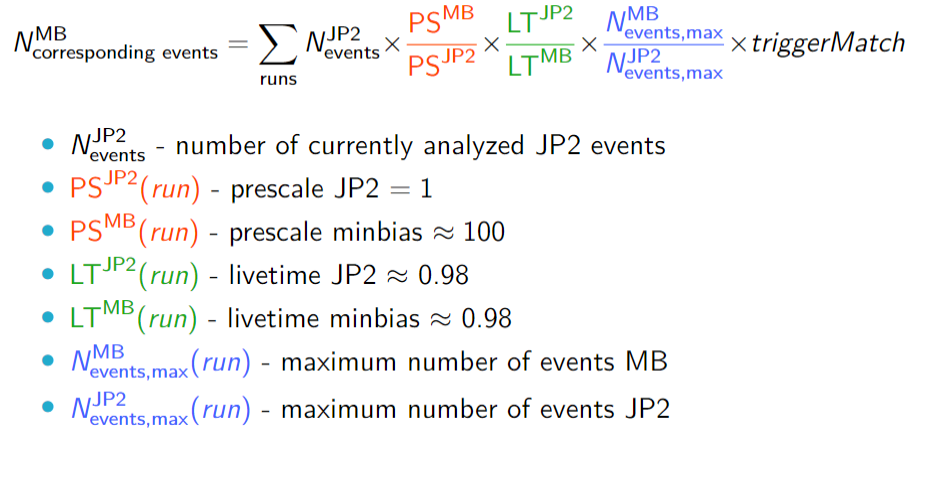

In [ ]:
%jsroot on
ROOT.gStyle.SetOptStat(0)
can = ROOT.TCanvas('can', 'can', 800, 600)
can.Draw()
can.SetLogy()

def dataframe_to_TH1(df,column, hist_name="hist"):
    """
    Convert a Pandas DataFrame with into a ROOT TH1D histogram.
    Returns:
    - ROOT.TH1D histogram with custom bin labels.
    """
    rows = df.index.to_list()  # Extract run IDs
    entries = df[column].to_list()  # Extract event counts
    name = df.index.name  # Get the name of the index column

    n_bins = len(rows)
    hist = ROOT.TH1D(hist_name, hist_name, n_bins, 0, n_bins)  # Create histogram

    # Assign bin labels and fill histogram
    for i, run_id in enumerate(rows):
        bin_index = i + 1  # ROOT bins start from 1
        hist.GetXaxis().SetBinLabel(bin_index, str(run_id))  # Set custom labels
        hist.SetBinContent(bin_index, entries[i])  # Fill with event counts
    return hist

trigger='MB'
root_file_path = path + f'jets_{trigger}.root'
root_file = uproot.open( root_file_path )
events_per_run = get_event_hist(root_file)
current_events_per_run = dataframe_to_TH1(events_per_run, "events", "current_events_per_run")


for trigger in triggers:
    prescale_ratio = dataframe_to_TH1(lumi, f'prescale_MB_over_{trigger}', f'prescale_MB_over_{trigger}')
    livetime_ratio = dataframe_to_TH1(lumi, f'livetime_{trigger}_over_MB', f'livetime_{trigger}_over_MB')
    maxnevent_ratio = dataframe_to_TH1(lumi, f'nevents_MB_over_{trigger}', f'nevents_MB_over_{trigger}')

    prescale_ratio.SetMarkerColor(2000) 
    prescale_ratio.SetLineColor(2000)
    prescale_ratio.SetMarkerStyle (20)
    prescale_ratio.SetMarkerSize(0.8)
    livetime_ratio.SetMarkerColor(2001)
    livetime_ratio.SetLineColor(2001)
    livetime_ratio.SetMarkerStyle (21)
    livetime_ratio.SetMarkerSize(0.8)

    maxnevent_ratio.SetMarkerColor(2002)
    maxnevent_ratio.SetLineColor(2002)
    maxnevent_ratio.SetMarkerStyle (22)
    maxnevent_ratio.SetMarkerSize(0.8)
   
    leg = ROOT.TLegend(0.6, 0.7, 0.9, 0.9)
    leg.AddEntry(prescale_ratio, f'prescale MB/{trigger}', 'p')
    leg.AddEntry(livetime_ratio, f'livetime {trigger}/MB', 'p')
    leg.AddEntry(maxnevent_ratio, f'maxnevents MB/{trigger}', 'p')
    prescale_ratio.SetTitle(f'{trigger};runid; ratio')
    # set grid


    prescale_ratio.GetYaxis().SetRangeUser(0.2, 10000)
    prescale_ratio.Draw("pl")
    livetime_ratio.Draw("lp same")
    maxnevent_ratio.Draw("lp same ")
    leg.Draw()
    can.SaveAs(f'plots/{trigger}_prescales_ratio.pdf')
